#DLG PROJECT

Adya Bhat, PES1UG22AM014

Diya M Hande, PES1UG22AM057

Hamsini V, PES1UG22AM062

Kirti S, PES1UG22AM084


# drug - drug

In [ ]:
!pip install torch torch-geometric pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
# with contrastive learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import HeteroData
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load Dataset
def load_drug_drug_graph(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['drug1', 'drug2']
    drug_set = pd.Index(pd.concat([df['drug1'], df['drug2']]).unique())
    drug_map = {k: i for i, k in enumerate(drug_set)}

    edge_index = torch.tensor([
        [drug_map[a] for a in df['drug1']],
        [drug_map[b] for b in df['drug2']]
    ], dtype=torch.long)

    data = HeteroData()
    data["drug"].num_nodes = len(drug_set)
    data["drug"].x = torch.randn(len(drug_set), 64)
    data["drug", "interacts", "drug"].edge_index = edge_index

    return data, drug_map


# Model
class DrugEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gat1 = GATConv(64, 64, heads=2, dropout=0.3)
        self.gat2 = GATConv(128, 64, heads=1, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return F.normalize(x, p=2, dim=1)


# Contrastive Loss
def contrastive_loss(anchor, positive, negative, margin=0.5):
    pos_sim = F.cosine_similarity(anchor, positive)
    neg_sim = F.cosine_similarity(anchor, negative)
    loss = torch.mean(F.relu(margin + neg_sim - pos_sim))
    return loss


# Split Edges
def split_edges(edge_index, test_ratio=0.2):
    edge_list = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    train_edges, test_edges = train_test_split(edge_list, test_size=test_ratio, random_state=42)

    def to_tensor_edges(edge_list):
        src, dst = zip(*edge_list)
        return torch.tensor([src, dst], dtype=torch.long)

    return to_tensor_edges(train_edges), to_tensor_edges(test_edges)


# Training
import copy

def train(model, x, edge_index, train_edges, test_edges, epochs=110):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    all_nodes = torch.arange(x.size(0))

    best_f1 = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        emb = model(x, edge_index)

        pos_src, pos_dst = train_edges
        anchor = emb[pos_src]
        positive = emb[pos_dst]

        existing_edges = set(zip(pos_src.tolist(), pos_dst.tolist()))
        neg_dst = []
        for src in pos_src:
            while True:
                neg = random.choice(all_nodes).item()
                if (src.item(), neg) not in existing_edges and src.item() != neg:
                    neg_dst.append(neg)
                    break
        negative = emb[torch.tensor(neg_dst)]

        loss = contrastive_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            f1 = evaluate(model, x, edge_index, test_edges, verbose=False)
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, F1: {f1:.4f}")
            if f1 > best_f1:
                best_f1 = f1
                best_model_state = copy.deepcopy(model.state_dict())

    print(f"\nBest F1-score during training: {best_f1:.4f}")
    if best_model_state:
        model.load_state_dict(best_model_state)


# Evaluation
@torch.no_grad()
def evaluate(model, x, edge_index, test_edges, verbose=True):
    model.eval()
    emb = model(x, edge_index)

    pos_src, pos_dst = test_edges
    pos_scores = F.cosine_similarity(emb[pos_src], emb[pos_dst])
    pos_labels = torch.ones_like(pos_scores)

    existing = set(zip(pos_src.tolist(), pos_dst.tolist()))
    neg_src, neg_dst = [], []
    for _ in range(len(pos_src)):
        while True:
            s, d = random.randint(0, emb.size(0)-1), random.randint(0, emb.size(0)-1)
            if (s, d) not in existing and s != d:
                neg_src.append(s)
                neg_dst.append(d)
                break

    neg_scores = F.cosine_similarity(emb[torch.tensor(neg_src)], emb[torch.tensor(neg_dst)])
    neg_labels = torch.zeros_like(neg_scores)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    preds = (scores > 0.5).float()

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    if verbose:
        print("\n=== Evaluation Metrics ===")
        print("Accuracy: ", acc)
        print("Precision:", prec)
        print("Recall:   ", rec)
        print("F1-score: ", f1)

    return f1

file_path = 'ChCh-Miner_durgbank-chem-chem.tsv'
data, node_map = load_drug_drug_graph(file_path)
edge_index = data["drug", "interacts", "drug"].edge_index
train_edges, test_edges = split_edges(edge_index)

model = DrugEncoder()
train(model, data["drug"].x, edge_index, train_edges, test_edges)
evaluate(model, data["drug"].x, edge_index, test_edges)


Epoch 0, Loss: 0.2860, F1: 0.7423
Epoch 10, Loss: 0.2254, F1: 0.7878
Epoch 20, Loss: 0.2116, F1: 0.8080
Epoch 30, Loss: 0.1969, F1: 0.8050
Epoch 40, Loss: 0.1915, F1: 0.8132
Epoch 50, Loss: 0.1871, F1: 0.8139
Epoch 60, Loss: 0.1818, F1: 0.8137
Epoch 70, Loss: 0.1833, F1: 0.8093
Epoch 80, Loss: 0.1845, F1: 0.8217
Epoch 90, Loss: 0.1798, F1: 0.8196
Epoch 100, Loss: 0.1756, F1: 0.8172
Epoch 109, Loss: 0.1792, F1: 0.8140

Best F1-score during training: 0.8217

=== Evaluation Metrics ===
Accuracy:  0.8234051324332681
Precision: 0.839463435742103
Recall:    0.7997526538184067
F1-score:  0.8191270385813058


0.8191270385813058

In [ ]:
# without con
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import HeteroData
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load Dataset
def load_drug_drug_graph(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['drug1', 'drug2']
    drug_set = pd.Index(pd.concat([df['drug1'], df['drug2']]).unique())
    drug_map = {k: i for i, k in enumerate(drug_set)}

    edge_index = torch.tensor([
        [drug_map[a] for a in df['drug1']],
        [drug_map[b] for b in df['drug2']]
    ], dtype=torch.long)

    data = HeteroData()
    data["drug"].num_nodes = len(drug_set)
    data["drug"].x = torch.randn(len(drug_set), 64)
    data["drug", "interacts", "drug"].edge_index = edge_index

    return data, drug_map


# Model
class DrugEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.gat1 = GATConv(64, 64, heads=2, dropout=0.3)
        self.gat2 = GATConv(128, 64, heads=1, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return x


# Edge Splitting
def split_edges(edge_index, test_ratio=0.2):
    edge_list = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    train_edges, test_edges = train_test_split(edge_list, test_size=test_ratio, random_state=42)

    def to_tensor_edges(edge_list):
        src, dst = zip(*edge_list)
        return torch.tensor([src, dst], dtype=torch.long)

    return to_tensor_edges(train_edges), to_tensor_edges(test_edges)


# Training
import copy

def train(model, x, edge_index, train_edges, test_edges, epochs=110):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    best_f1 = 0.0
    best_model_state = None

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        emb = model(x, edge_index)

        # Positive samples
        pos_src, pos_dst = train_edges
        pos_scores = (emb[pos_src] * emb[pos_dst]).sum(dim=1)
        pos_labels = torch.ones_like(pos_scores)

        # Negative samples
        existing = set(zip(pos_src.tolist(), pos_dst.tolist()))
        neg_src, neg_dst = [], []
        for _ in range(len(pos_src)):
            while True:
                s, d = random.randint(0, emb.size(0)-1), random.randint(0, emb.size(0)-1)
                if (s, d) not in existing and s != d:
                    neg_src.append(s)
                    neg_dst.append(d)
                    break
        neg_src, neg_dst = torch.tensor(neg_src), torch.tensor(neg_dst)
        neg_scores = (emb[neg_src] * emb[neg_dst]).sum(dim=1)
        neg_labels = torch.zeros_like(neg_scores)

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([pos_labels, neg_labels])
        loss = criterion(scores, labels)

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            f1 = evaluate(model, x, edge_index, test_edges, verbose=False)
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, F1: {f1:.4f}")
            if f1 > best_f1:
                best_f1 = f1
                best_model_state = copy.deepcopy(model.state_dict())

    print(f"\nBest F1-score during training: {best_f1:.4f}")
    if best_model_state:
        model.load_state_dict(best_model_state)


# Evaluation
@torch.no_grad()
def evaluate(model, x, edge_index, test_edges, verbose=True):
    model.eval()
    emb = model(x, edge_index)

    pos_src, pos_dst = test_edges
    pos_scores = (emb[pos_src] * emb[pos_dst]).sum(dim=1)
    pos_labels = torch.ones_like(pos_scores)

    existing = set(zip(pos_src.tolist(), pos_dst.tolist()))
    neg_src, neg_dst = [], []
    for _ in range(len(pos_src)):
        while True:
            s, d = random.randint(0, emb.size(0)-1), random.randint(0, emb.size(0)-1)
            if (s, d) not in existing and s != d:
                neg_src.append(s)
                neg_dst.append(d)
                break
    neg_src, neg_dst = torch.tensor(neg_src), torch.tensor(neg_dst)
    neg_scores = (emb[neg_src] * emb[neg_dst]).sum(dim=1)
    neg_labels = torch.zeros_like(neg_scores)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels])
    preds = (torch.sigmoid(scores) > 0.5).float()

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    if verbose:
        print("\n=== Evaluation Metrics ===")
        print("Accuracy: ", acc)
        print("Precision:", prec)
        print("Recall:   ", rec)
        print("F1-score: ", f1)

    return f1

file_path = 'ChCh-Miner_durgbank-chem-chem.tsv'
data, node_map = load_drug_drug_graph(file_path)
edge_index = data["drug", "interacts", "drug"].edge_index
train_edges, test_edges = split_edges(edge_index)

model = DrugEncoder()
train(model, data["drug"].x, edge_index, train_edges, test_edges)
evaluate(model, data["drug"].x, edge_index, test_edges)

Epoch 0, Loss: 1.0393, F1: 0.6948
Epoch 10, Loss: 0.6524, F1: 0.7230
Epoch 20, Loss: 0.6311, F1: 0.7341
Epoch 30, Loss: 0.6117, F1: 0.7482
Epoch 40, Loss: 0.5946, F1: 0.7637
Epoch 50, Loss: 0.5822, F1: 0.7701
Epoch 60, Loss: 0.5779, F1: 0.7765
Epoch 70, Loss: 0.5669, F1: 0.7800
Epoch 80, Loss: 0.5631, F1: 0.7790
Epoch 90, Loss: 0.5593, F1: 0.7845
Epoch 100, Loss: 0.5538, F1: 0.7852
Epoch 109, Loss: 0.5507, F1: 0.7908

Best F1-score during training: 0.7908

=== Evaluation Metrics ===
Accuracy:  0.7425023188704525
Precision: 0.6680714285714285
Recall:    0.9639286818509739
F1-score:  0.7891828038644897


0.7891828038644897

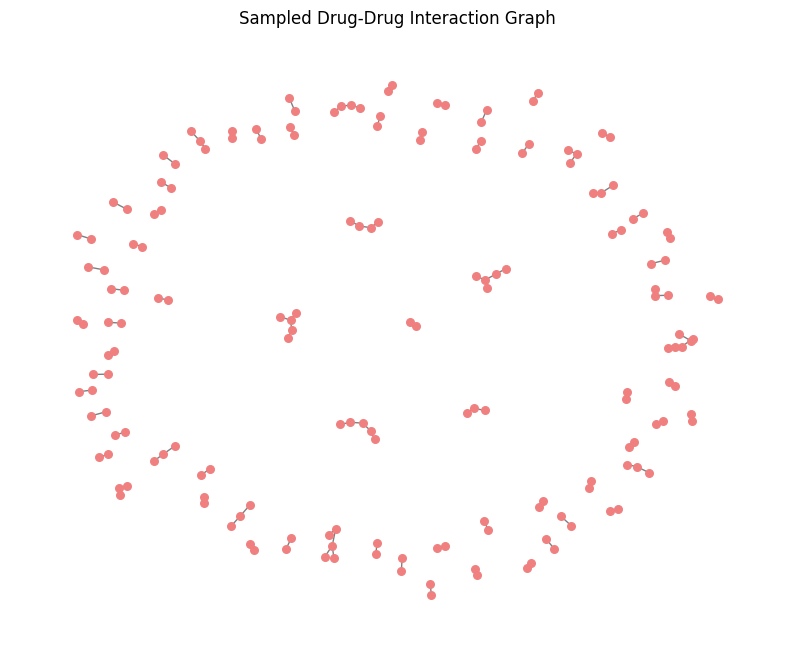

In [ ]:
# visualization
import pandas as pd
import torch
from torch_geometric.data import HeteroData
import networkx as nx
import matplotlib.pyplot as plt
import random

def load_drug_drug_graph(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['drug1', 'drug2']

    drug_set = pd.Index(pd.concat([df['drug1'], df['drug2']]).unique())
    drug_map = {k: i for i, k in enumerate(drug_set)}

    edge_index = torch.tensor([
        [drug_map[a] for a in df['drug1']],
        [drug_map[b] for b in df['drug2']]
    ], dtype=torch.long)

    data = HeteroData()
    data["drug"].num_nodes = len(drug_set)
    data["drug"].x = torch.randn(len(drug_set), 64)
    data["drug", "interacts", "drug"].edge_index = edge_index

    return data

def visualize_drug_graph(data, num_edges=100):
    edge_index = data["drug", "interacts", "drug"].edge_index
    G = nx.Graph()

    edge_list = edge_index.t().tolist()
    sampled_edges = random.sample(edge_list, min(num_edges, len(edge_list)))

    G.add_edges_from(sampled_edges)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=30, node_color='lightcoral')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Sampled Drug-Drug Interaction Graph")
    plt.axis('off')
    plt.show()

# Run
file_path = 'ChCh-Miner_durgbank-chem-chem.tsv'
data = load_drug_drug_graph(file_path)
visualize_drug_graph(data)


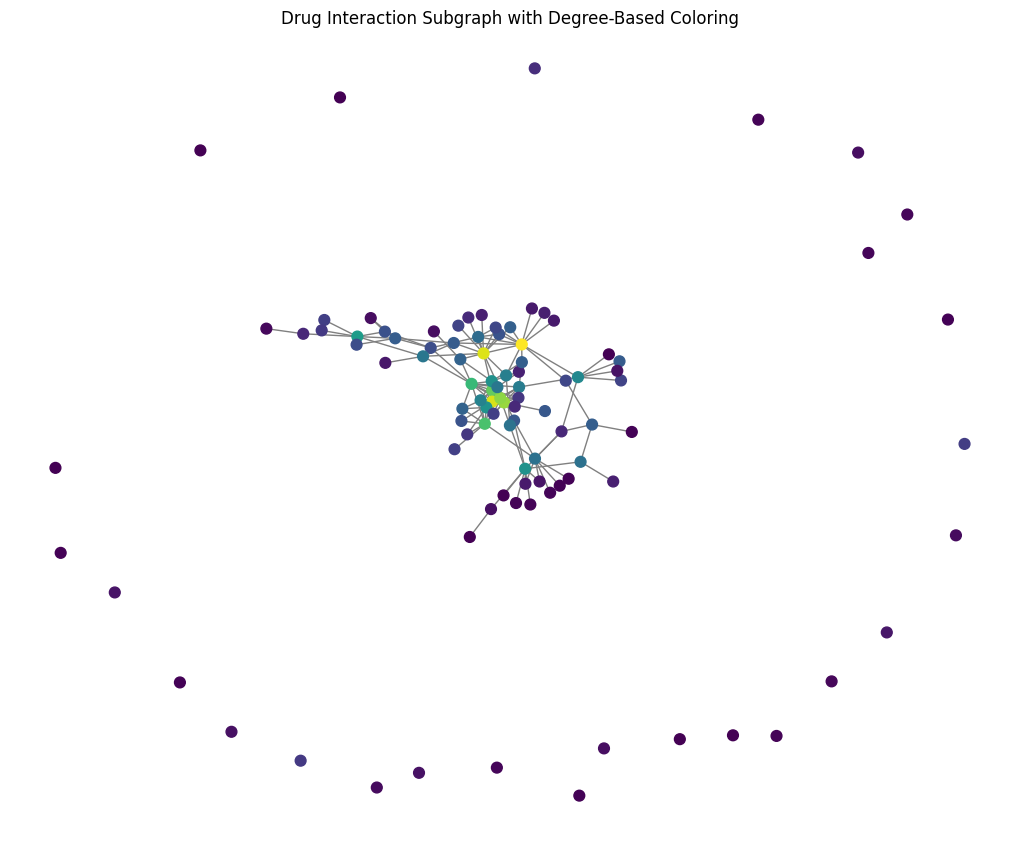

In [ ]:
def visualize_degree_colored_graph(data, num_edges=200):
    edge_index = data["drug", "interacts", "drug"].edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    # Compute degree centrality
    degree_dict = dict(G.degree())
    node_color = [degree_dict[n] for n in G.nodes]

    # Sample subgraph
    nodes_sample = random.sample(list(G.nodes), min(100, len(G.nodes)))
    subgraph = G.subgraph(nodes_sample)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph, seed=42)
    nx.draw(subgraph, pos, with_labels=False, node_color=[degree_dict[n] for n in subgraph.nodes],
            node_size=60, edge_color='gray', cmap=plt.cm.viridis)
    plt.title("Drug Interaction Subgraph with Degree-Based Coloring")
    plt.axis('off')
    plt.show()
data = load_drug_drug_graph(file_path)
visualize_degree_colored_graph(data, num_edges=200)

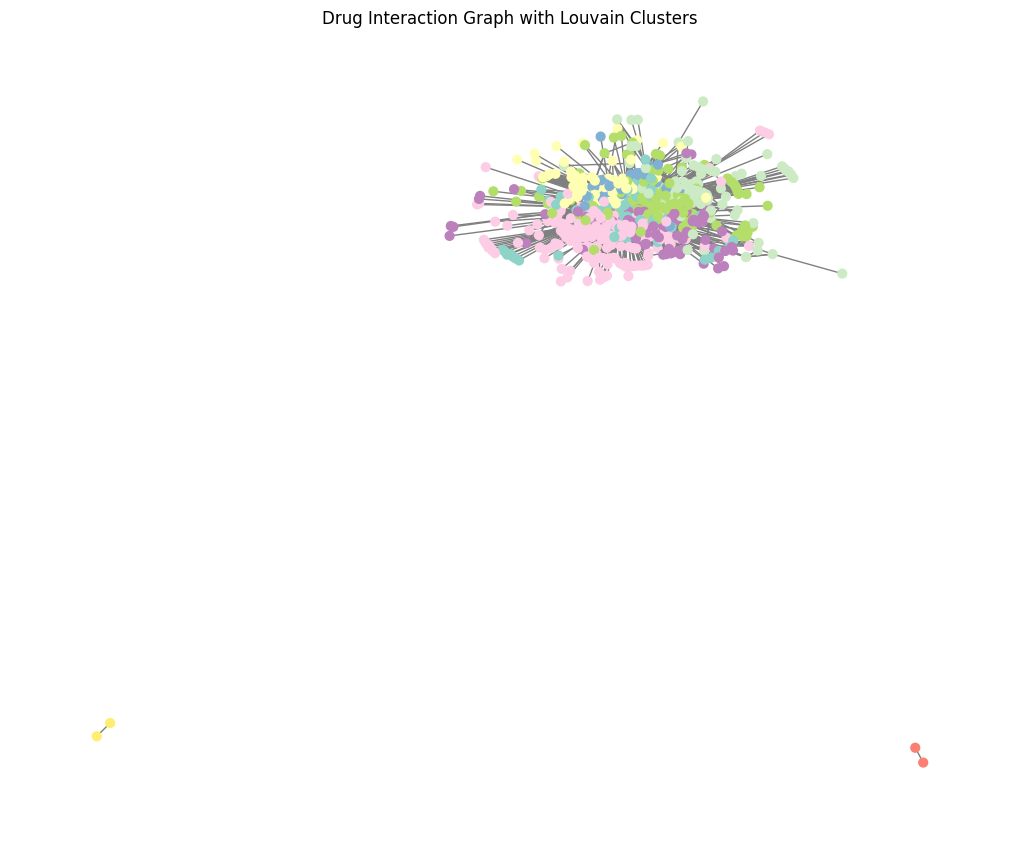

In [ ]:
import community as community_louvain

def visualize_clustered_graph(data):
    edge_index = data["drug", "interacts", "drug"].edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    # Detect communities
    partition = community_louvain.best_partition(G)
    colors = [partition[n] for n in G.nodes]

    # Visualize
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_color=colors, node_size=40, cmap=plt.cm.Set3, edge_color='gray')
    plt.title("Drug Interaction Graph with Louvain Clusters")
    plt.axis('off')
    plt.show()
visualize_clustered_graph(data)

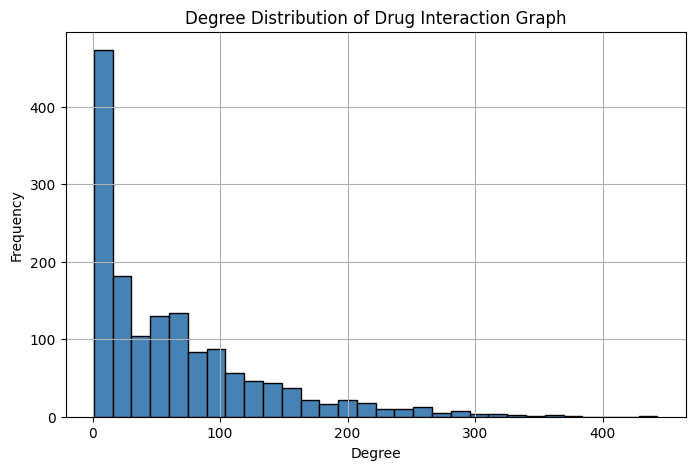

In [ ]:
def plot_degree_distribution(data):
    edge_index = data["drug", "interacts", "drug"].edge_index
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())

    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(8, 5))
    plt.hist(degrees, bins=30, color='steelblue', edgecolor='black')
    plt.title("Degree Distribution of Drug Interaction Graph")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
plot_degree_distribution(data)

# food - drug

In [ ]:
!pip install torch torch-geometric pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
!git clone https://github.com/Hyeramoon/NLP_food_drug_interaction.git


Cloning into 'NLP_food_drug_interaction'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39 (from 1)
Receiving objects: 100% (39/39), 7.91 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (30/30), done.


In [ ]:
import os

# Walk through the directory and print all files
for root, dirs, files in os.walk('NLP_food_drug_interaction'):
    for file in files:
        print(os.path.join(root, file))


NLP_food_drug_interaction/README.md
NLP_food_drug_interaction/.git/description
NLP_food_drug_interaction/.git/HEAD
NLP_food_drug_interaction/.git/index
NLP_food_drug_interaction/.git/packed-refs
NLP_food_drug_interaction/.git/config
NLP_food_drug_interaction/.git/logs/HEAD
NLP_food_drug_interaction/.git/logs/refs/remotes/origin/HEAD
NLP_food_drug_interaction/.git/logs/refs/heads/master
NLP_food_drug_interaction/.git/hooks/prepare-commit-msg.sample
NLP_food_drug_interaction/.git/hooks/fsmonitor-watchman.sample
NLP_food_drug_interaction/.git/hooks/applypatch-msg.sample
NLP_food_drug_interaction/.git/hooks/post-update.sample
NLP_food_drug_interaction/.git/hooks/pre-commit.sample
NLP_food_drug_interaction/.git/hooks/commit-msg.sample
NLP_food_drug_interaction/.git/hooks/update.sample
NLP_food_drug_interaction/.git/hooks/pre-receive.sample
NLP_food_drug_interaction/.git/hooks/pre-merge-commit.sample
NLP_food_drug_interaction/.git/hooks/pre-rebase.sample
NLP_food_drug_interaction/.git/hooks/

In [ ]:
import os
import shutil

root_dir = 'NLP_food_drug_interaction/FinalProject'
keep_folder = os.path.join(root_dir, 'data')

# Loop through everything in the main project directory
for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if item_path != keep_folder:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)

# Confirm what remains
print("Remaining contents:", os.listdir(root_dir))


Remaining contents: ['data']


In [ ]:
import pandas as pd

data_path = 'NLP_food_drug_interaction/FinalProject/data/labeled_dataAll.csv'
df = pd.read_csv(data_path)

# Show first few rows
df.head()


,ID,Label_alpha,Label_num,Drug,Food,sentence
0,400,neutral,1,ACE inhibitor,pentadecanoic acid,(123)iodine labelled beta-methyl-iodophenyl pe...
1,333,positive,2,ACE inhibitor,2-phenylethanol,2-Phenylethanol is a widely used aroma compoun...
2,77,positive,2,ACE inhibitor,"3,4-dihydroxyphenylacetic acid","3,4-dihydroxyphenylacetic acid and 4-methylcat..."
3,338,neutral,1,ACE inhibitor,arachin,A 96-well microplate format of this method was...
4,214,neutral,1,ACE inhibitor,diethylamine,A biochemical study was performed in order to ...


In [ ]:
print(drug_le.classes_)
print(food_le.classes_)


['ACE inhibitor' 'Acetaminophen' 'Analgesics' 'Antacid' 'Antihistamine'
 'Bronchodialators' 'Digoxin' 'GLP-1' 'Isoniazid' 'MOAI' 'Statin'
 'Thyroxine']
['(-)-borneol' '(r)-citronellal' '1,3-butanediol' '1,4-benzoquinone'
 '1,4-naphthoquinone' '1,5-dihydroxyxanthone' '1-butanol'
 '1-chloro-2,4-dinitrobenzene' '1-hexanol' '1-naphthaldehyde' '1-octanol'
 '1-pentanol' '1-propanol' '12-hete' '15-hete' '17alpha-ethynylestradiol'
 '17beta-estriol' '2,3-dihydroxybenzoic acid' '2,4-decadienal'
 '2,4-dihydroxybenzoic acid' '2,4-dinitrophenylhydrazone'
 '2-amino-3-methylimidazo[4,5-f]quinoline' '2-bromophenol' '2-butanone'
 '2-hydroxyphenylacetic acid' '2-oxoglutarate' '2-phenylethanol'
 '2-propanol' '25-hydroxycholecalciferol' '3,4-dihydroxyphenylacetic acid'
 '3,5-di-o-caffeoylquinic acid' '3-hydroxyanthranilic acid'
 '3-mercaptopyruvate' '3-methylglutaconyl-coa' "4'-hydroxyacetophenone"
 '4-ethylphenol' '4-hydroxybenzoate' '4-hydroxybenzoic acid'
 '4-hydroxyphenylacetic acid' '4-methylphenol' 

In [ ]:
print("Columns:", df.columns)
print("\nLabel distribution:")
print(df['Label_alpha'].value_counts())  # or whatever the label column is called


Columns: Index(['ID', 'Label_alpha', 'Label_num', 'Drug', 'Food', 'sentence'], dtype='object')

Label distribution:
Label_alpha
neutral     1581
positive     531
negative     359
Name: count, dtype: int64


In [ ]:
import networkx as nx

G = nx.Graph()

for idx, row in df.iterrows():
    drug = row['Drug']
    food = row['Food']
    label = row['Label_alpha']

    G.add_node(drug, type='drug')
    G.add_node(food, type='food')

    G.add_edge(drug, food, interaction=label)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 994
Number of edges: 1424


Subgraph nodes: ['ACE inhibitor', 'allium', 'Antihistamine', 'Acetaminophen', 'Digoxin', 'Thyroxine']
Subgraph edges: [('ACE inhibitor', 'allium'), ('allium', 'Thyroxine'), ('allium', 'Acetaminophen'), ('allium', 'Digoxin'), ('allium', 'Antihistamine')]


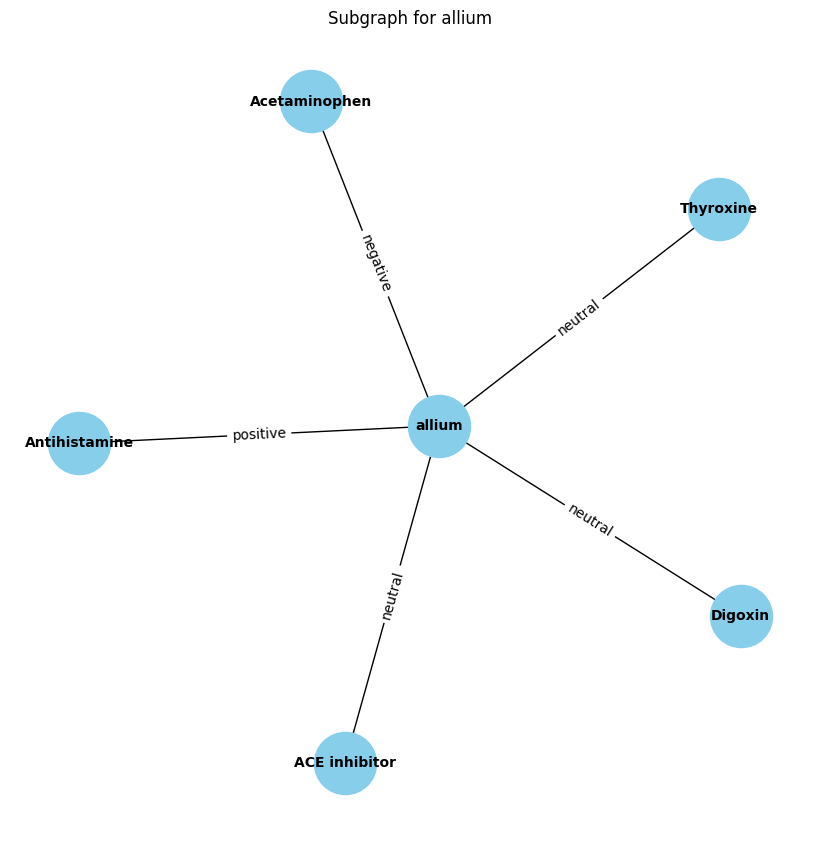

In [ ]:
import matplotlib.pyplot as plt

food_item = 'allium'

neighbors = list(G.neighbors(food_item))

subgraph = G.subgraph([food_item] + neighbors)

print(f"Subgraph nodes: {subgraph.nodes()}")
print(f"Subgraph edges: {subgraph.edges()}")

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=2000, font_size=10, font_weight='bold', node_color='skyblue')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): data['interaction'] for u, v, data in subgraph.edges(data=True)})
plt.title(f"Subgraph for {food_item}")
plt.show()


In [ ]:
#With CL Model

import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Load Data
df = pd.read_csv("/content/NLP_food_drug_interaction/FinalProject/data/labeled_dataAll.csv")
pickle_file_path = '/content/NLP_food_drug_interaction/FinalProject/data/food_common.pickle'
try:
    with open(pickle_file_path, 'rb') as f:
        food_common_data = pickle.load(f, encoding='utf-8')
    print(f"Loaded pickle from {pickle_file_path}")
except:
    food_common_data = defaultdict(list)
    food_common_data['FoodX'] = ["Water", "Calcium", "VitaminC"]
    food_common_data['FoodY'] = ["Protein", "Iron", "VitaminA"]
    food_common_data['FoodZ'] = ["Fiber", "Potassium", "Water"]
    print("Using dummy pickle data")

# Label Encoding & Feature Prep
drug_le = LabelEncoder()
food_le = LabelEncoder()
df['drug_id'] = drug_le.fit_transform(df['Drug'])
df['food_id'] = food_le.fit_transform(df['Food'])
num_drugs = len(drug_le.classes_)
num_foods = len(food_le.classes_)

all_common_items = set()
for items in food_common_data.values():
    all_common_items.update(items)
item_to_idx = {item: i for i, item in enumerate(sorted(list(all_common_items)))}
food_features = torch.zeros(num_foods, len(item_to_idx))
food_name_to_id = {name: id for id, name in enumerate(food_le.classes_)}
for food_name, items in food_common_data.items():
    if food_name in food_name_to_id:
        food_id = food_name_to_id[food_name]
        for item in items:
            if item in item_to_idx:
                food_features[food_id, item_to_idx[item]] = 1.0

# Graph Construction
data = HeteroData()
data['food'].x = food_features
data['drug'].num_nodes = num_drugs

df_balanced = df[['drug_id', 'food_id', 'Label_num']].rename(columns={'Label_num': 'label'})
df_neg = df_balanced[df_balanced['label'] == 0]
df_neu = df_balanced[df_balanced['label'] == 1]
df_pos = df_balanced[df_balanced['label'] == 2]
df_pos_oversampled = resample(df_pos, replace=True, n_samples=len(df_neu), random_state=42)
df_neg_oversampled = resample(df_neg, replace=True, n_samples=len(df_neu), random_state=42)
df_balanced = pd.concat([df_pos_oversampled, df_neg_oversampled, df_neu])
print("Balanced class distribution:\n", df_balanced['label'].value_counts())

edge_index = torch.tensor([df_balanced['drug_id'].values, df_balanced['food_id'].values])
edge_label = torch.tensor(df_balanced['label'].values)

data['drug', 'interacts', 'food'].edge_index = edge_index
data['drug', 'interacts', 'food'].edge_label = edge_label
rev_edge_index = torch.stack([edge_index[1], edge_index[0]], dim=0)
data['food', 'rev_interacts', 'drug'].edge_index = rev_edge_index
data['food', 'rev_interacts', 'drug'].edge_label = edge_label

transform = RandomLinkSplit(
    num_val=0.1, num_test=0.1, neg_sampling_ratio=0.0,
    is_undirected=False, split_labels=True,
    edge_types=[('drug', 'interacts', 'food')],
    rev_edge_types=[('food', 'rev_interacts', 'drug')]
)
train_data, val_data, test_data = transform(data)

# Contrastive Loss
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        anchor_dot_contrast = torch.div(torch.matmul(features, features.T), self.temperature)
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(labels.shape[0], device=device))
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-9)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1)
        return -mean_log_prob_pos.mean()

# Optional Label Smoothing
class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        num_classes = pred.size(1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred, dim=1), dim=1))

# GNN Model
class HeteroGNN(nn.Module):
    def __init__(self, hidden_channels, num_classes, num_drugs, num_foods, drug_emb_dim, food_emb_dim):
        super().__init__()
        self.drug_emb = nn.Embedding(num_drugs, drug_emb_dim)
        self.food_emb = nn.Embedding(num_foods, food_emb_dim)
        self.conv1 = HeteroConv({
            ('food', 'rev_interacts', 'drug'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interacts', 'food'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('food', 'rev_interacts', 'drug'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interacts', 'food'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.projection_head = nn.Sequential(
            nn.Linear(2 * hidden_channels, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.classifier = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels // 2, num_classes)
        )

    def forward(self, x_dict, edge_index_dict):
        x_dict = x_dict.copy()
        x_dict['drug'] = self.drug_emb(torch.arange(self.drug_emb.num_embeddings, device=self.drug_emb.weight.device))
        x_dict['food'] = self.food_emb(torch.arange(self.food_emb.num_embeddings, device=self.food_emb.weight.device))
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=0.5, training=self.training) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def decode(self, z_dict, edge_index):
        z = torch.cat([z_dict['drug'][edge_index[0]], z_dict['food'][edge_index[1]]], dim=1)
        z = F.normalize(z, p=2, dim=1)
        return self.classifier(z), self.projection_head(z)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(128, 3, num_drugs, num_foods, 64, 64).to(device)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
ce_loss = LabelSmoothingCE(smoothing=0.1)  # You can switch this back to nn.CrossEntropyLoss()
con_loss = SupervisedContrastiveLoss()

# Training Loop
print("\nStarting Training...")
for epoch in tqdm(range(1, 1001)):
    model.train()
    optimizer.zero_grad()
    z_dict = model(train_data.x_dict, train_data.edge_index_dict)
    edge_idx = train_data['drug', 'interacts', 'food'].pos_edge_label_index
    labels = train_data['drug', 'interacts', 'food'].pos_edge_label
    logits, proj = model.decode(z_dict, edge_idx)
    ce = ce_loss(logits, labels)
    con = con_loss(F.normalize(proj, dim=1), labels)
    loss = ce + 0.15 * con
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            z_dict = model(val_data.x_dict, val_data.edge_index_dict)
            edge_idx = val_data['drug', 'interacts', 'food'].pos_edge_label_index
            val_logits, val_proj = model.decode(z_dict, edge_idx)
            val_labels = val_data['drug', 'interacts', 'food'].pos_edge_label
            val_ce = ce_loss(val_logits, val_labels)
            val_acc = val_logits.argmax(1).eq(val_labels).float().mean().item()
        print(f"Epoch {epoch} | CE Loss: {ce.item():.4f} | Contrastive: {con.item():.4f} | Val Loss: {val_ce.item():.4f} | Val Acc: {val_acc:.4f}")

# Test
model.eval()
with torch.no_grad():
    z_dict = model(test_data.x_dict, test_data.edge_index_dict)
    edge_idx = test_data['drug', 'interacts', 'food'].pos_edge_label_index
    test_logits, _ = model.decode(z_dict, edge_idx)
    test_labels = test_data['drug', 'interacts', 'food'].pos_edge_label
    test_loss = ce_loss(test_logits, test_labels)
    test_acc = test_logits.argmax(1).eq(test_labels).float().mean().item()
print(f"\nTest Loss: {test_loss.item():.4f} | Test Accuracy: {test_acc:.4f}")


Loaded pickle from /content/NLP_food_drug_interaction/FinalProject/data/food_common.pickle
Balanced class distribution:
 label
2    1581
0    1581
1    1581
Name: count, dtype: int64

Starting Training...


  1%|          | 6/1000 [00:00<00:17, 55.77it/s]

Epoch 10 | CE Loss: 1.0301 | Contrastive: 8.2246 | Val Loss: 1.0182 | Val Acc: 0.5253


  2%|▏         | 21/1000 [00:00<00:16, 60.06it/s]

Epoch 20 | CE Loss: 0.9779 | Contrastive: 8.1814 | Val Loss: 0.9775 | Val Acc: 0.5717


  3%|▎         | 30/1000 [00:00<00:15, 63.00it/s]

Epoch 30 | CE Loss: 0.9338 | Contrastive: 8.1447 | Val Loss: 0.9613 | Val Acc: 0.5844


  4%|▍         | 40/1000 [00:00<00:14, 65.60it/s]

Epoch 40 | CE Loss: 0.9214 | Contrastive: 8.1350 | Val Loss: 0.9299 | Val Acc: 0.6139


  5%|▌         | 50/1000 [00:00<00:14, 67.06it/s]

Epoch 50 | CE Loss: 0.9069 | Contrastive: 8.1151 | Val Loss: 0.9285 | Val Acc: 0.6224


  6%|▌         | 60/1000 [00:00<00:13, 67.95it/s]

Epoch 60 | CE Loss: 0.8548 | Contrastive: 8.0624 | Val Loss: 0.8917 | Val Acc: 0.6603


  7%|▋         | 70/1000 [00:01<00:13, 68.41it/s]

Epoch 70 | CE Loss: 0.8148 | Contrastive: 8.0021 | Val Loss: 0.8974 | Val Acc: 0.6392


  8%|▊         | 80/1000 [00:01<00:13, 68.74it/s]

Epoch 80 | CE Loss: 0.7996 | Contrastive: 7.9756 | Val Loss: 0.8356 | Val Acc: 0.6941


  9%|▉         | 90/1000 [00:01<00:13, 68.52it/s]

Epoch 90 | CE Loss: 0.7456 | Contrastive: 7.9308 | Val Loss: 0.8093 | Val Acc: 0.7257


 10%|█         | 100/1000 [00:01<00:13, 68.69it/s]

Epoch 100 | CE Loss: 0.7270 | Contrastive: 7.9030 | Val Loss: 0.7989 | Val Acc: 0.7363


 11%|█         | 110/1000 [00:01<00:12, 68.94it/s]

Epoch 110 | CE Loss: 0.7023 | Contrastive: 7.8652 | Val Loss: 0.7992 | Val Acc: 0.7384


 12%|█▏        | 120/1000 [00:01<00:12, 69.14it/s]

Epoch 120 | CE Loss: 0.6972 | Contrastive: 7.8561 | Val Loss: 0.7797 | Val Acc: 0.7616


 13%|█▎        | 128/1000 [00:01<00:12, 69.89it/s]

Epoch 130 | CE Loss: 0.6933 | Contrastive: 7.8435 | Val Loss: 0.7780 | Val Acc: 0.7658


 14%|█▍        | 144/1000 [00:02<00:12, 69.83it/s]

Epoch 140 | CE Loss: 0.6907 | Contrastive: 7.8397 | Val Loss: 0.7765 | Val Acc: 0.7637


 15%|█▌        | 151/1000 [00:02<00:12, 67.67it/s]

Epoch 150 | CE Loss: 0.6854 | Contrastive: 7.8277 | Val Loss: 0.7766 | Val Acc: 0.7637


 16%|█▌        | 160/1000 [00:02<00:12, 67.43it/s]

Epoch 160 | CE Loss: 0.6850 | Contrastive: 7.8293 | Val Loss: 0.7617 | Val Acc: 0.7700


 17%|█▋        | 170/1000 [00:02<00:12, 67.61it/s]

Epoch 170 | CE Loss: 0.6814 | Contrastive: 7.8270 | Val Loss: 0.7812 | Val Acc: 0.7553


 18%|█▊        | 180/1000 [00:02<00:12, 67.77it/s]

Epoch 180 | CE Loss: 0.6781 | Contrastive: 7.8168 | Val Loss: 0.7608 | Val Acc: 0.7616


 19%|█▉        | 190/1000 [00:02<00:11, 67.70it/s]

Epoch 190 | CE Loss: 0.6720 | Contrastive: 7.8152 | Val Loss: 0.7591 | Val Acc: 0.7658


 20%|██        | 200/1000 [00:02<00:11, 67.51it/s]

Epoch 200 | CE Loss: 0.6672 | Contrastive: 7.7865 | Val Loss: 0.7746 | Val Acc: 0.7574


 21%|██        | 210/1000 [00:03<00:11, 67.75it/s]

Epoch 210 | CE Loss: 0.6612 | Contrastive: 7.7696 | Val Loss: 0.7596 | Val Acc: 0.7616


 22%|██▏       | 220/1000 [00:03<00:11, 67.85it/s]

Epoch 220 | CE Loss: 0.6570 | Contrastive: 7.7609 | Val Loss: 0.7551 | Val Acc: 0.7722


 23%|██▎       | 230/1000 [00:03<00:11, 68.18it/s]

Epoch 230 | CE Loss: 0.6458 | Contrastive: 7.7450 | Val Loss: 0.7537 | Val Acc: 0.7806


 24%|██▍       | 239/1000 [00:03<00:10, 72.15it/s]

Epoch 240 | CE Loss: 0.6451 | Contrastive: 7.7255 | Val Loss: 0.7561 | Val Acc: 0.7764


 25%|██▍       | 247/1000 [00:03<00:10, 71.21it/s]

Epoch 250 | CE Loss: 0.6361 | Contrastive: 7.7227 | Val Loss: 0.7472 | Val Acc: 0.7785


 26%|██▌       | 262/1000 [00:03<00:10, 68.33it/s]

Epoch 260 | CE Loss: 0.6410 | Contrastive: 7.7234 | Val Loss: 0.7453 | Val Acc: 0.7890


 27%|██▋       | 270/1000 [00:03<00:10, 67.09it/s]

Epoch 270 | CE Loss: 0.6356 | Contrastive: 7.7146 | Val Loss: 0.7477 | Val Acc: 0.7827


 28%|██▊       | 280/1000 [00:04<00:10, 67.73it/s]

Epoch 280 | CE Loss: 0.6364 | Contrastive: 7.7182 | Val Loss: 0.7427 | Val Acc: 0.7848


 29%|██▉       | 290/1000 [00:04<00:10, 68.11it/s]

Epoch 290 | CE Loss: 0.6341 | Contrastive: 7.7159 | Val Loss: 0.7413 | Val Acc: 0.7932


 30%|███       | 300/1000 [00:04<00:10, 68.35it/s]

Epoch 300 | CE Loss: 0.6332 | Contrastive: 7.7078 | Val Loss: 0.7369 | Val Acc: 0.7975


 31%|███       | 310/1000 [00:04<00:10, 68.24it/s]

Epoch 310 | CE Loss: 0.6268 | Contrastive: 7.7061 | Val Loss: 0.7376 | Val Acc: 0.7954


 32%|███▏      | 320/1000 [00:04<00:09, 68.31it/s]

Epoch 320 | CE Loss: 0.6293 | Contrastive: 7.6963 | Val Loss: 0.7371 | Val Acc: 0.7954


 33%|███▎      | 330/1000 [00:04<00:09, 68.42it/s]

Epoch 330 | CE Loss: 0.6246 | Contrastive: 7.6942 | Val Loss: 0.7376 | Val Acc: 0.7932


 34%|███▍      | 340/1000 [00:04<00:09, 68.62it/s]

Epoch 340 | CE Loss: 0.6276 | Contrastive: 7.6965 | Val Loss: 0.7374 | Val Acc: 0.7954


 35%|███▌      | 350/1000 [00:05<00:09, 68.73it/s]

Epoch 350 | CE Loss: 0.6292 | Contrastive: 7.6948 | Val Loss: 0.7374 | Val Acc: 0.7954


 36%|███▌      | 360/1000 [00:05<00:09, 68.85it/s]

Epoch 360 | CE Loss: 0.6276 | Contrastive: 7.7339 | Val Loss: 0.7375 | Val Acc: 0.7932


 37%|███▋      | 370/1000 [00:05<00:09, 68.80it/s]

Epoch 370 | CE Loss: 0.6303 | Contrastive: 7.7282 | Val Loss: 0.7331 | Val Acc: 0.7975


 38%|███▊      | 380/1000 [00:05<00:09, 68.77it/s]

Epoch 380 | CE Loss: 0.6328 | Contrastive: 7.7293 | Val Loss: 0.7428 | Val Acc: 0.7890


 39%|███▉      | 390/1000 [00:05<00:08, 68.68it/s]

Epoch 390 | CE Loss: 0.6356 | Contrastive: 7.7451 | Val Loss: 0.7343 | Val Acc: 0.8038


 40%|████      | 400/1000 [00:05<00:08, 68.80it/s]

Epoch 400 | CE Loss: 0.6312 | Contrastive: 7.7086 | Val Loss: 0.7406 | Val Acc: 0.7954


 41%|████      | 410/1000 [00:06<00:08, 68.74it/s]

Epoch 410 | CE Loss: 0.6266 | Contrastive: 7.7090 | Val Loss: 0.7310 | Val Acc: 0.7954


 42%|████▏     | 420/1000 [00:06<00:08, 68.75it/s]

Epoch 420 | CE Loss: 0.6226 | Contrastive: 7.6997 | Val Loss: 0.7324 | Val Acc: 0.7932


 43%|████▎     | 430/1000 [00:06<00:08, 68.67it/s]

Epoch 430 | CE Loss: 0.6258 | Contrastive: 7.6965 | Val Loss: 0.7294 | Val Acc: 0.7996


 44%|████▍     | 440/1000 [00:06<00:08, 68.76it/s]

Epoch 440 | CE Loss: 0.6185 | Contrastive: 7.6895 | Val Loss: 0.7382 | Val Acc: 0.7932


 45%|████▌     | 450/1000 [00:06<00:08, 68.68it/s]

Epoch 450 | CE Loss: 0.6134 | Contrastive: 7.6831 | Val Loss: 0.7346 | Val Acc: 0.7996


 46%|████▌     | 460/1000 [00:06<00:07, 68.71it/s]

Epoch 460 | CE Loss: 0.6159 | Contrastive: 7.6873 | Val Loss: 0.7452 | Val Acc: 0.7806


 47%|████▋     | 470/1000 [00:06<00:07, 68.66it/s]

Epoch 470 | CE Loss: 0.6137 | Contrastive: 7.6813 | Val Loss: 0.7383 | Val Acc: 0.7890


 48%|████▊     | 480/1000 [00:07<00:07, 68.69it/s]

Epoch 480 | CE Loss: 0.6127 | Contrastive: 7.6719 | Val Loss: 0.7392 | Val Acc: 0.7890


 49%|████▉     | 490/1000 [00:07<00:07, 68.70it/s]

Epoch 490 | CE Loss: 0.6063 | Contrastive: 7.6647 | Val Loss: 0.7283 | Val Acc: 0.7890


 50%|█████     | 500/1000 [00:07<00:07, 68.85it/s]

Epoch 500 | CE Loss: 0.6098 | Contrastive: 7.6645 | Val Loss: 0.7350 | Val Acc: 0.7869


 51%|█████     | 510/1000 [00:07<00:07, 68.81it/s]

Epoch 510 | CE Loss: 0.6005 | Contrastive: 7.6589 | Val Loss: 0.7305 | Val Acc: 0.7827


 52%|█████▏    | 520/1000 [00:07<00:06, 68.80it/s]

Epoch 520 | CE Loss: 0.6014 | Contrastive: 7.6553 | Val Loss: 0.7209 | Val Acc: 0.7932


 53%|█████▎    | 530/1000 [00:07<00:06, 68.72it/s]

Epoch 530 | CE Loss: 0.6017 | Contrastive: 7.6560 | Val Loss: 0.7304 | Val Acc: 0.7848


 54%|█████▍    | 540/1000 [00:07<00:06, 68.77it/s]

Epoch 540 | CE Loss: 0.6012 | Contrastive: 7.6590 | Val Loss: 0.7252 | Val Acc: 0.7932


 55%|█████▌    | 550/1000 [00:08<00:06, 68.73it/s]

Epoch 550 | CE Loss: 0.5957 | Contrastive: 7.6473 | Val Loss: 0.7302 | Val Acc: 0.7911


 56%|█████▌    | 560/1000 [00:08<00:06, 68.62it/s]

Epoch 560 | CE Loss: 0.5990 | Contrastive: 7.6522 | Val Loss: 0.7251 | Val Acc: 0.7975


 57%|█████▋    | 570/1000 [00:08<00:06, 68.61it/s]

Epoch 570 | CE Loss: 0.5951 | Contrastive: 7.6421 | Val Loss: 0.7222 | Val Acc: 0.7911


 58%|█████▊    | 580/1000 [00:08<00:06, 68.70it/s]

Epoch 580 | CE Loss: 0.5970 | Contrastive: 7.6482 | Val Loss: 0.7228 | Val Acc: 0.7911


 59%|█████▉    | 590/1000 [00:08<00:05, 68.59it/s]

Epoch 590 | CE Loss: 0.5973 | Contrastive: 7.6445 | Val Loss: 0.7253 | Val Acc: 0.7911


 60%|██████    | 600/1000 [00:08<00:05, 68.81it/s]

Epoch 600 | CE Loss: 0.5940 | Contrastive: 7.6375 | Val Loss: 0.7226 | Val Acc: 0.7869


 61%|██████    | 610/1000 [00:08<00:05, 68.82it/s]

Epoch 610 | CE Loss: 0.5968 | Contrastive: 7.6484 | Val Loss: 0.7200 | Val Acc: 0.7869


 62%|██████▏   | 620/1000 [00:09<00:05, 68.80it/s]

Epoch 620 | CE Loss: 0.6015 | Contrastive: 7.6404 | Val Loss: 0.7182 | Val Acc: 0.7869


 63%|██████▎   | 630/1000 [00:09<00:05, 68.23it/s]

Epoch 630 | CE Loss: 0.5925 | Contrastive: 7.6375 | Val Loss: 0.7213 | Val Acc: 0.7869


 64%|██████▍   | 640/1000 [00:09<00:05, 68.43it/s]

Epoch 640 | CE Loss: 0.5980 | Contrastive: 7.6450 | Val Loss: 0.7180 | Val Acc: 0.7932


 65%|██████▌   | 650/1000 [00:09<00:05, 68.37it/s]

Epoch 650 | CE Loss: 0.5953 | Contrastive: 7.6364 | Val Loss: 0.7185 | Val Acc: 0.7890


 66%|██████▌   | 660/1000 [00:09<00:04, 68.48it/s]

Epoch 660 | CE Loss: 0.5947 | Contrastive: 7.6357 | Val Loss: 0.7157 | Val Acc: 0.7890


 67%|██████▋   | 670/1000 [00:09<00:04, 68.32it/s]

Epoch 670 | CE Loss: 0.5933 | Contrastive: 7.6335 | Val Loss: 0.7167 | Val Acc: 0.7869


 68%|██████▊   | 680/1000 [00:09<00:04, 68.29it/s]

Epoch 680 | CE Loss: 0.5895 | Contrastive: 7.6294 | Val Loss: 0.7169 | Val Acc: 0.7848


 69%|██████▉   | 690/1000 [00:10<00:04, 68.36it/s]

Epoch 690 | CE Loss: 0.5962 | Contrastive: 7.6349 | Val Loss: 0.7154 | Val Acc: 0.7911


 70%|███████   | 700/1000 [00:10<00:04, 68.17it/s]

Epoch 700 | CE Loss: 0.5985 | Contrastive: 7.6369 | Val Loss: 0.7154 | Val Acc: 0.7890


 71%|███████   | 710/1000 [00:10<00:04, 68.03it/s]

Epoch 710 | CE Loss: 0.5887 | Contrastive: 7.6328 | Val Loss: 0.7150 | Val Acc: 0.7954


 72%|███████▏  | 720/1000 [00:10<00:04, 68.26it/s]

Epoch 720 | CE Loss: 0.5906 | Contrastive: 7.6294 | Val Loss: 0.7153 | Val Acc: 0.7911


 73%|███████▎  | 730/1000 [00:10<00:03, 68.21it/s]

Epoch 730 | CE Loss: 0.5979 | Contrastive: 7.6330 | Val Loss: 0.7157 | Val Acc: 0.7890


 74%|███████▍  | 740/1000 [00:10<00:03, 68.45it/s]

Epoch 740 | CE Loss: 0.5890 | Contrastive: 7.6283 | Val Loss: 0.7157 | Val Acc: 0.7911


 75%|███████▌  | 750/1000 [00:10<00:03, 68.46it/s]

Epoch 750 | CE Loss: 0.5942 | Contrastive: 7.6284 | Val Loss: 0.7157 | Val Acc: 0.7911


 76%|███████▌  | 760/1000 [00:11<00:03, 68.35it/s]

Epoch 760 | CE Loss: 0.6064 | Contrastive: 7.6583 | Val Loss: 0.7150 | Val Acc: 0.7932


 77%|███████▋  | 770/1000 [00:11<00:03, 67.95it/s]

Epoch 770 | CE Loss: 0.6010 | Contrastive: 7.6657 | Val Loss: 0.7226 | Val Acc: 0.7869


 78%|███████▊  | 780/1000 [00:11<00:03, 68.25it/s]

Epoch 780 | CE Loss: 0.6068 | Contrastive: 7.6757 | Val Loss: 0.7179 | Val Acc: 0.7869


 79%|███████▉  | 790/1000 [00:11<00:03, 68.18it/s]

Epoch 790 | CE Loss: 0.6080 | Contrastive: 7.6819 | Val Loss: 0.7226 | Val Acc: 0.7869


 80%|████████  | 800/1000 [00:11<00:02, 68.25it/s]

Epoch 800 | CE Loss: 0.6115 | Contrastive: 7.6806 | Val Loss: 0.7243 | Val Acc: 0.7785


 81%|████████  | 810/1000 [00:11<00:02, 68.24it/s]

Epoch 810 | CE Loss: 0.6028 | Contrastive: 7.6682 | Val Loss: 0.7284 | Val Acc: 0.7785


 82%|████████▏ | 820/1000 [00:11<00:02, 68.38it/s]

Epoch 820 | CE Loss: 0.5989 | Contrastive: 7.6564 | Val Loss: 0.7321 | Val Acc: 0.7827


 83%|████████▎ | 830/1000 [00:12<00:02, 68.24it/s]

Epoch 830 | CE Loss: 0.5977 | Contrastive: 7.6556 | Val Loss: 0.7114 | Val Acc: 0.7975


 84%|████████▍ | 840/1000 [00:12<00:02, 68.23it/s]

Epoch 840 | CE Loss: 0.6069 | Contrastive: 7.6640 | Val Loss: 0.7187 | Val Acc: 0.7954


 85%|████████▌ | 850/1000 [00:12<00:02, 68.41it/s]

Epoch 850 | CE Loss: 0.5998 | Contrastive: 7.6653 | Val Loss: 0.7224 | Val Acc: 0.7869


 86%|████████▌ | 860/1000 [00:12<00:02, 68.45it/s]

Epoch 860 | CE Loss: 0.5962 | Contrastive: 7.6508 | Val Loss: 0.7138 | Val Acc: 0.8059


 87%|████████▋ | 870/1000 [00:12<00:01, 68.35it/s]

Epoch 870 | CE Loss: 0.5925 | Contrastive: 7.6377 | Val Loss: 0.7040 | Val Acc: 0.8143


 88%|████████▊ | 880/1000 [00:12<00:01, 68.51it/s]

Epoch 880 | CE Loss: 0.5948 | Contrastive: 7.6372 | Val Loss: 0.7091 | Val Acc: 0.8017


 89%|████████▉ | 890/1000 [00:13<00:01, 68.22it/s]

Epoch 890 | CE Loss: 0.5878 | Contrastive: 7.6346 | Val Loss: 0.7117 | Val Acc: 0.7932


 90%|█████████ | 900/1000 [00:13<00:01, 68.25it/s]

Epoch 900 | CE Loss: 0.5902 | Contrastive: 7.6409 | Val Loss: 0.7013 | Val Acc: 0.8101


 91%|█████████ | 910/1000 [00:13<00:01, 68.22it/s]

Epoch 910 | CE Loss: 0.5952 | Contrastive: 7.6418 | Val Loss: 0.6973 | Val Acc: 0.8143


 92%|█████████▏| 920/1000 [00:13<00:01, 68.32it/s]

Epoch 920 | CE Loss: 0.5875 | Contrastive: 7.6323 | Val Loss: 0.7022 | Val Acc: 0.8080


 93%|█████████▎| 930/1000 [00:13<00:01, 68.08it/s]

Epoch 930 | CE Loss: 0.5862 | Contrastive: 7.6283 | Val Loss: 0.7035 | Val Acc: 0.8059


 94%|█████████▍| 940/1000 [00:13<00:00, 68.22it/s]

Epoch 940 | CE Loss: 0.5858 | Contrastive: 7.6271 | Val Loss: 0.7137 | Val Acc: 0.7932


 95%|█████████▌| 950/1000 [00:13<00:00, 68.27it/s]

Epoch 950 | CE Loss: 0.5867 | Contrastive: 7.6317 | Val Loss: 0.6926 | Val Acc: 0.8143


 96%|█████████▌| 959/1000 [00:14<00:00, 71.15it/s]

Epoch 960 | CE Loss: 0.5858 | Contrastive: 7.6360 | Val Loss: 0.6923 | Val Acc: 0.8143


 97%|█████████▋| 967/1000 [00:14<00:00, 70.78it/s]

Epoch 970 | CE Loss: 0.5846 | Contrastive: 7.6324 | Val Loss: 0.6927 | Val Acc: 0.8059


 98%|█████████▊| 982/1000 [00:14<00:00, 67.88it/s]

Epoch 980 | CE Loss: 0.5891 | Contrastive: 7.6269 | Val Loss: 0.6894 | Val Acc: 0.8101


 99%|█████████▉| 990/1000 [00:14<00:00, 66.83it/s]

Epoch 990 | CE Loss: 0.5861 | Contrastive: 7.6301 | Val Loss: 0.6907 | Val Acc: 0.8207


100%|██████████| 1000/1000 [00:14<00:00, 68.35it/s]

Epoch 1000 | CE Loss: 0.5821 | Contrastive: 7.6249 | Val Loss: 0.6829 | Val Acc: 0.8249

Test Loss: 0.6729 | Test Accuracy: 0.8608



 Test Set Evaluation Results 
Test Accuracy: 0.8608
Test Loss (Avg): 0.6729

Classification Report:
                    precision    recall  f1-score   support

Label 0 (Negative)     0.7833    0.9463    0.8571       149
 Label 1 (Neutral)     0.9037    0.7771    0.8356       157
Label 2 (Positive)     0.9119    0.8631    0.8869       168

          accuracy                         0.8608       474
         macro avg     0.8663    0.8622    0.8599       474
      weighted avg     0.8688    0.8608    0.8605       474


Confusion Matrix:
[[141   5   3]
 [ 24 122  11]
 [ 15   8 145]]


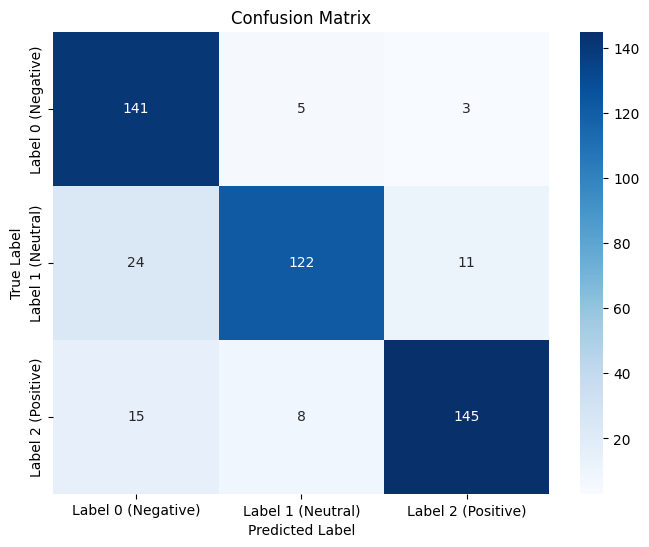

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_test_preds = []
all_test_labels = []
test_loss_total = 0.0
test_steps = 0

with torch.no_grad():
    z_dict_test = model(test_data.x_dict, test_data.edge_index_dict)

    edge_idx_test = test_data['drug', 'interacts', 'food'].pos_edge_label_index
    test_labels = test_data['drug', 'interacts', 'food'].pos_edge_label

    if edge_idx_test.numel() > 0:
        test_logits, _ = model.decode(z_dict_test, edge_idx_test)
        test_loss = ce_loss(test_logits, test_labels)
        test_loss_total += test_loss.item()
        test_steps += 1

        preds = test_logits.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(test_labels.cpu().numpy())
    else:
        print("\nWarning: No positive test edges found.")

avg_test_loss = test_loss_total / test_steps if test_steps > 0 else 0.0


if all_test_labels:
    print("\n" + "="*30)
    print(" Test Set Evaluation Results ")
    print("="*30)

    accuracy = accuracy_score(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss (Avg): {avg_test_loss:.4f}\n")
    target_names = ['Label 0 (Negative)', 'Label 1 (Neutral)', 'Label 2 (Positive)']
    present_labels = sorted(np.unique(all_test_labels + all_test_preds))
    report_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

    print("Classification Report:")
    try:
        report = classification_report(all_test_labels, all_test_preds,
                                       labels=present_labels,
                                       target_names=report_target_names,
                                       digits=4,
                                       zero_division=0)
        print(report)
    except ValueError as e:
         print(f"Could not generate classification report: {e}")
         print("Check if labels/predictions contain unexpected values.")
         print("True labels present:", np.unique(all_test_labels))
         print("Predicted labels present:", np.unique(all_test_preds))

    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(all_test_labels, all_test_preds, labels=present_labels)
        print(cm)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=report_target_names,
                    yticklabels=report_target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print(f"Could not generate or plot confusion matrix: {e}")

else:
    print("\nNo test predictions were made (e.g., empty test set or no positive links). Cannot evaluate metrics.")


In [ ]:
print("\nSample Predictions:")
num_samples = 10
sample_indices = torch.randperm(edge_idx.size(1))[:num_samples]
sample_edge_idx = edge_idx[:, sample_indices]
sample_logits, _ = model.decode(z_dict, sample_edge_idx)
sample_preds = sample_logits.argmax(dim=1)
sample_true = test_labels[sample_indices]

inv_drug_le = {v: k for k, v in enumerate(drug_le.classes_)}
inv_food_le = {v: k for k, v in enumerate(food_le.classes_)}

for i in range(num_samples):
    drug_id = sample_edge_idx[0, i].item()
    food_id = sample_edge_idx[1, i].item()
    drug_name = drug_le.inverse_transform([drug_id])[0]
    food_name = food_le.inverse_transform([food_id])[0]
    pred_label = sample_preds[i].item()
    true_label = sample_true[i].item()
    print(f"{i+1}: Drug: {drug_name:<25} | Food: {food_name:<25} | Predicted: {pred_label} | Actual: {true_label}")



Sample Predictions:
1: Drug: Antihistamine             | Food: inosine                   | Predicted: 0 | Actual: 1
2: Drug: ACE inhibitor             | Food: ginger                    | Predicted: 2 | Actual: 2
3: Drug: Statin                    | Food: arsenic                   | Predicted: 0 | Actual: 0
4: Drug: Digoxin                   | Food: angelica                  | Predicted: 1 | Actual: 1
5: Drug: Antacid                   | Food: spinach                   | Predicted: 2 | Actual: 2
6: Drug: Statin                    | Food: vinegar                   | Predicted: 1 | Actual: 1
7: Drug: ACE inhibitor             | Food: lentils                   | Predicted: 2 | Actual: 2
8: Drug: ACE inhibitor             | Food: sake                      | Predicted: 2 | Actual: 2
9: Drug: ACE inhibitor             | Food: sauce                     | Predicted: 2 | Actual: 2
10: Drug: Statin                    | Food: spirit                    | Predicted: 1 | Actual: 1


In [ ]:
# Model Without CL
class HeteroGNN_NoContrast(nn.Module):
    def __init__(self, hidden_channels, num_classes, num_drugs, num_foods, drug_emb_dim, food_emb_dim):
        super().__init__()
        self.drug_emb = nn.Embedding(num_drugs, drug_emb_dim)
        self.food_emb = nn.Embedding(num_foods, food_emb_dim)
        self.conv1 = HeteroConv({
            ('food', 'rev_interacts', 'drug'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interacts', 'food'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('food', 'rev_interacts', 'drug'): SAGEConv((-1, -1), hidden_channels),
            ('drug', 'interacts', 'food'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.classifier = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_channels // 2, num_classes)
        )

    def forward(self, x_dict, edge_index_dict):
        x_dict = x_dict.copy()
        x_dict['drug'] = self.drug_emb(torch.arange(self.drug_emb.num_embeddings, device=self.drug_emb.weight.device))
        x_dict['food'] = self.food_emb(torch.arange(self.food_emb.num_embeddings, device=self.food_emb.weight.device))
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=0.5, training=self.training) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def decode(self, z_dict, edge_index):
        z = torch.cat([z_dict['drug'][edge_index[0]], z_dict['food'][edge_index[1]]], dim=1)
        return self.classifier(z)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN_NoContrast(128, 3, num_drugs, num_foods, 64, 64).to(device)
train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
ce_loss = LabelSmoothingCE(smoothing=0.1)  # Or use nn.CrossEntropyLoss()

# Training Loop (No Contrastive)
print("\nStarting Training (No Contrastive Learning)...")
for epoch in tqdm(range(1, 1001)):
    model.train()
    optimizer.zero_grad()
    z_dict = model(train_data.x_dict, train_data.edge_index_dict)
    edge_idx = train_data['drug', 'interacts', 'food'].pos_edge_label_index
    labels = train_data['drug', 'interacts', 'food'].pos_edge_label
    logits = model.decode(z_dict, edge_idx)
    loss = ce_loss(logits, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            z_dict = model(val_data.x_dict, val_data.edge_index_dict)
            edge_idx = val_data['drug', 'interacts', 'food'].pos_edge_label_index
            val_logits = model.decode(z_dict, edge_idx)
            val_labels = val_data['drug', 'interacts', 'food'].pos_edge_label
            val_loss = ce_loss(val_logits, val_labels)
            val_acc = val_logits.argmax(1).eq(val_labels).float().mean().item()
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

# Final Test
model.eval()
with torch.no_grad():
    z_dict = model(test_data.x_dict, test_data.edge_index_dict)
    edge_idx = test_data['drug', 'interacts', 'food'].pos_edge_label_index
    test_logits = model.decode(z_dict, edge_idx)
    test_labels = test_data['drug', 'interacts', 'food'].pos_edge_label
    test_loss = ce_loss(test_logits, test_labels)
    test_acc = test_logits.argmax(1).eq(test_labels).float().mean().item()
print(f"\n[NO Contrastive] Test Loss: {test_loss.item():.4f} | Test Accuracy: {test_acc:.4f}")



Starting Training (No Contrastive Learning)...


  2%|▏         | 17/1000 [00:00<00:05, 166.77it/s]

Epoch 10 | Loss: 1.0137 | Val Loss: 0.9852 | Val Acc: 0.5190
Epoch 20 | Loss: 0.9752 | Val Loss: 0.9474 | Val Acc: 0.5970
Epoch 30 | Loss: 0.9323 | Val Loss: 0.9195 | Val Acc: 0.6224


  3%|▎         | 34/1000 [00:00<00:06, 154.31it/s]

Epoch 40 | Loss: 0.9005 | Val Loss: 0.8945 | Val Acc: 0.6266


  7%|▋         | 68/1000 [00:00<00:05, 160.05it/s]

Epoch 50 | Loss: 0.8966 | Val Loss: 0.8871 | Val Acc: 0.6224
Epoch 60 | Loss: 0.8445 | Val Loss: 0.8284 | Val Acc: 0.6920
Epoch 70 | Loss: 0.8068 | Val Loss: 0.7896 | Val Acc: 0.7194
Epoch 80 | Loss: 0.7633 | Val Loss: 0.7585 | Val Acc: 0.7511


 10%|█         | 102/1000 [00:00<00:05, 158.54it/s]

Epoch 90 | Loss: 0.7370 | Val Loss: 0.7293 | Val Acc: 0.7743
Epoch 100 | Loss: 0.7105 | Val Loss: 0.7169 | Val Acc: 0.7848
Epoch 110 | Loss: 0.6883 | Val Loss: 0.7104 | Val Acc: 0.7890


 12%|█▏        | 120/1000 [00:00<00:05, 161.94it/s]

Epoch 120 | Loss: 0.6789 | Val Loss: 0.7097 | Val Acc: 0.7911


 14%|█▎        | 137/1000 [00:00<00:05, 162.75it/s]

Epoch 130 | Loss: 0.6746 | Val Loss: 0.7024 | Val Acc: 0.8038
Epoch 140 | Loss: 0.6798 | Val Loss: 0.7012 | Val Acc: 0.8038
Epoch 150 | Loss: 0.6719 | Val Loss: 0.7012 | Val Acc: 0.8017


 15%|█▌        | 154/1000 [00:00<00:05, 163.58it/s]

Epoch 160 | Loss: 0.6884 | Val Loss: 0.7142 | Val Acc: 0.7890


 19%|█▉        | 189/1000 [00:01<00:04, 165.86it/s]

Epoch 170 | Loss: 0.6694 | Val Loss: 0.6991 | Val Acc: 0.8059
Epoch 180 | Loss: 0.6764 | Val Loss: 0.6829 | Val Acc: 0.8186
Epoch 190 | Loss: 0.6715 | Val Loss: 0.7117 | Val Acc: 0.8038
Epoch 200 | Loss: 0.6624 | Val Loss: 0.6987 | Val Acc: 0.7996


 22%|██▏       | 223/1000 [00:01<00:04, 160.70it/s]

Epoch 210 | Loss: 0.6545 | Val Loss: 0.7032 | Val Acc: 0.8038
Epoch 220 | Loss: 0.6415 | Val Loss: 0.6980 | Val Acc: 0.8207
Epoch 230 | Loss: 0.6364 | Val Loss: 0.6896 | Val Acc: 0.8122


 24%|██▍       | 240/1000 [00:01<00:04, 158.32it/s]

Epoch 240 | Loss: 0.6345 | Val Loss: 0.6888 | Val Acc: 0.8270


 26%|██▌       | 257/1000 [00:01<00:04, 161.55it/s]

Epoch 250 | Loss: 0.6334 | Val Loss: 0.6804 | Val Acc: 0.8270
Epoch 260 | Loss: 0.6350 | Val Loss: 0.6869 | Val Acc: 0.8333
Epoch 270 | Loss: 0.6289 | Val Loss: 0.6779 | Val Acc: 0.8291


 27%|██▋       | 274/1000 [00:01<00:04, 161.81it/s]

Epoch 280 | Loss: 0.6214 | Val Loss: 0.6692 | Val Acc: 0.8354


 31%|███       | 309/1000 [00:01<00:04, 165.62it/s]

Epoch 290 | Loss: 0.6283 | Val Loss: 0.6719 | Val Acc: 0.8291
Epoch 300 | Loss: 0.6231 | Val Loss: 0.6731 | Val Acc: 0.8333
Epoch 310 | Loss: 0.6174 | Val Loss: 0.6696 | Val Acc: 0.8376
Epoch 320 | Loss: 0.6160 | Val Loss: 0.6710 | Val Acc: 0.8333


 34%|███▍      | 343/1000 [00:02<00:04, 163.93it/s]

Epoch 330 | Loss: 0.6153 | Val Loss: 0.6710 | Val Acc: 0.8333
Epoch 340 | Loss: 0.6142 | Val Loss: 0.6709 | Val Acc: 0.8333
Epoch 350 | Loss: 0.6132 | Val Loss: 0.6709 | Val Acc: 0.8333


 36%|███▌      | 360/1000 [00:02<00:03, 165.67it/s]

Epoch 360 | Loss: 0.6330 | Val Loss: 0.6776 | Val Acc: 0.8354


 38%|███▊      | 377/1000 [00:02<00:03, 160.49it/s]

Epoch 370 | Loss: 0.6426 | Val Loss: 0.6837 | Val Acc: 0.8376
Epoch 380 | Loss: 0.6420 | Val Loss: 0.6803 | Val Acc: 0.8249
Epoch 390 | Loss: 0.6360 | Val Loss: 0.6714 | Val Acc: 0.8460


 39%|███▉      | 394/1000 [00:02<00:03, 159.91it/s]

Epoch 400 | Loss: 0.6229 | Val Loss: 0.6798 | Val Acc: 0.8312


 43%|████▎     | 428/1000 [00:02<00:03, 163.81it/s]

Epoch 410 | Loss: 0.6368 | Val Loss: 0.6806 | Val Acc: 0.8186
Epoch 420 | Loss: 0.6184 | Val Loss: 0.6889 | Val Acc: 0.8249
Epoch 430 | Loss: 0.6072 | Val Loss: 0.6769 | Val Acc: 0.8249
Epoch 440 | Loss: 0.6123 | Val Loss: 0.6848 | Val Acc: 0.8312


 46%|████▌     | 462/1000 [00:02<00:03, 165.76it/s]

Epoch 450 | Loss: 0.6069 | Val Loss: 0.6812 | Val Acc: 0.8291
Epoch 460 | Loss: 0.6072 | Val Loss: 0.6813 | Val Acc: 0.8186
Epoch 470 | Loss: 0.6082 | Val Loss: 0.6746 | Val Acc: 0.8312


 48%|████▊     | 479/1000 [00:02<00:03, 165.17it/s]

Epoch 480 | Loss: 0.6069 | Val Loss: 0.6729 | Val Acc: 0.8228


 51%|█████▏    | 513/1000 [00:03<00:02, 164.93it/s]

Epoch 490 | Loss: 0.6088 | Val Loss: 0.6815 | Val Acc: 0.8059
Epoch 500 | Loss: 0.6044 | Val Loss: 0.6793 | Val Acc: 0.8228
Epoch 510 | Loss: 0.6008 | Val Loss: 0.6678 | Val Acc: 0.8291
Epoch 520 | Loss: 0.5914 | Val Loss: 0.6669 | Val Acc: 0.8270


 55%|█████▍    | 547/1000 [00:03<00:02, 154.17it/s]

Epoch 530 | Loss: 0.5946 | Val Loss: 0.6761 | Val Acc: 0.8207
Epoch 540 | Loss: 0.5966 | Val Loss: 0.6764 | Val Acc: 0.8207
Epoch 550 | Loss: 0.5990 | Val Loss: 0.6694 | Val Acc: 0.8270


 58%|█████▊    | 580/1000 [00:03<00:02, 155.87it/s]

Epoch 560 | Loss: 0.5915 | Val Loss: 0.6655 | Val Acc: 0.8270
Epoch 570 | Loss: 0.5905 | Val Loss: 0.6693 | Val Acc: 0.8249
Epoch 580 | Loss: 0.5961 | Val Loss: 0.6704 | Val Acc: 0.8270
Epoch 590 | Loss: 0.5955 | Val Loss: 0.6630 | Val Acc: 0.8333


 61%|██████▏   | 614/1000 [00:03<00:02, 159.54it/s]

Epoch 600 | Loss: 0.5886 | Val Loss: 0.6657 | Val Acc: 0.8270
Epoch 610 | Loss: 0.5906 | Val Loss: 0.6576 | Val Acc: 0.8312
Epoch 620 | Loss: 0.5884 | Val Loss: 0.6597 | Val Acc: 0.8333


 63%|██████▎   | 631/1000 [00:03<00:02, 161.67it/s]

Epoch 630 | Loss: 0.5838 | Val Loss: 0.6640 | Val Acc: 0.8291


 65%|██████▍   | 649/1000 [00:04<00:02, 164.57it/s]

Epoch 640 | Loss: 0.5840 | Val Loss: 0.6638 | Val Acc: 0.8312
Epoch 650 | Loss: 0.5868 | Val Loss: 0.6634 | Val Acc: 0.8291
Epoch 660 | Loss: 0.5846 | Val Loss: 0.6600 | Val Acc: 0.8354


 67%|██████▋   | 666/1000 [00:04<00:02, 164.89it/s]

Epoch 670 | Loss: 0.5881 | Val Loss: 0.6627 | Val Acc: 0.8376


 70%|███████   | 700/1000 [00:04<00:01, 161.46it/s]

Epoch 680 | Loss: 0.5895 | Val Loss: 0.6604 | Val Acc: 0.8333
Epoch 690 | Loss: 0.5821 | Val Loss: 0.6597 | Val Acc: 0.8333
Epoch 700 | Loss: 0.5832 | Val Loss: 0.6600 | Val Acc: 0.8333
Epoch 710 | Loss: 0.5899 | Val Loss: 0.6594 | Val Acc: 0.8333


 73%|███████▎  | 734/1000 [00:04<00:01, 161.06it/s]

Epoch 720 | Loss: 0.5803 | Val Loss: 0.6591 | Val Acc: 0.8354
Epoch 730 | Loss: 0.5807 | Val Loss: 0.6591 | Val Acc: 0.8354
Epoch 740 | Loss: 0.5808 | Val Loss: 0.6591 | Val Acc: 0.8354


 75%|███████▌  | 751/1000 [00:04<00:01, 162.89it/s]

Epoch 750 | Loss: 0.5849 | Val Loss: 0.6591 | Val Acc: 0.8354


 77%|███████▋  | 768/1000 [00:04<00:01, 164.22it/s]

Epoch 760 | Loss: 0.6000 | Val Loss: 0.6676 | Val Acc: 0.8291
Epoch 770 | Loss: 0.6006 | Val Loss: 0.6650 | Val Acc: 0.8333
Epoch 780 | Loss: 0.6016 | Val Loss: 0.6820 | Val Acc: 0.8291


 78%|███████▊  | 785/1000 [00:04<00:01, 163.61it/s]

Epoch 790 | Loss: 0.6067 | Val Loss: 0.6800 | Val Acc: 0.8228


 82%|████████▏ | 819/1000 [00:05<00:01, 165.46it/s]

Epoch 800 | Loss: 0.5960 | Val Loss: 0.6616 | Val Acc: 0.8333
Epoch 810 | Loss: 0.5968 | Val Loss: 0.6621 | Val Acc: 0.8122
Epoch 820 | Loss: 0.5968 | Val Loss: 0.6716 | Val Acc: 0.8270
Epoch 830 | Loss: 0.5936 | Val Loss: 0.6632 | Val Acc: 0.8312


 85%|████████▌ | 854/1000 [00:05<00:00, 166.55it/s]

Epoch 840 | Loss: 0.5954 | Val Loss: 0.6682 | Val Acc: 0.8333
Epoch 850 | Loss: 0.5905 | Val Loss: 0.6648 | Val Acc: 0.8312
Epoch 860 | Loss: 0.5871 | Val Loss: 0.6632 | Val Acc: 0.8333


 87%|████████▋ | 871/1000 [00:05<00:00, 158.25it/s]

Epoch 870 | Loss: 0.5899 | Val Loss: 0.6690 | Val Acc: 0.8333


 89%|████████▉ | 888/1000 [00:05<00:00, 160.86it/s]

Epoch 880 | Loss: 0.5859 | Val Loss: 0.6542 | Val Acc: 0.8333
Epoch 890 | Loss: 0.5878 | Val Loss: 0.6634 | Val Acc: 0.8291
Epoch 900 | Loss: 0.5889 | Val Loss: 0.6662 | Val Acc: 0.8312


 90%|█████████ | 905/1000 [00:05<00:00, 161.86it/s]

Epoch 910 | Loss: 0.5903 | Val Loss: 0.6690 | Val Acc: 0.8186


 94%|█████████▍| 939/1000 [00:05<00:00, 163.25it/s]

Epoch 920 | Loss: 0.5831 | Val Loss: 0.6643 | Val Acc: 0.8228
Epoch 930 | Loss: 0.5813 | Val Loss: 0.6535 | Val Acc: 0.8333
Epoch 940 | Loss: 0.5832 | Val Loss: 0.6573 | Val Acc: 0.8376
Epoch 950 | Loss: 0.5762 | Val Loss: 0.6570 | Val Acc: 0.8418


 97%|█████████▋| 973/1000 [00:06<00:00, 163.82it/s]

Epoch 960 | Loss: 0.5781 | Val Loss: 0.6619 | Val Acc: 0.8354
Epoch 970 | Loss: 0.5778 | Val Loss: 0.6623 | Val Acc: 0.8228
Epoch 980 | Loss: 0.5856 | Val Loss: 0.6645 | Val Acc: 0.8312


 99%|█████████▉| 990/1000 [00:06<00:00, 164.81it/s]

Epoch 990 | Loss: 0.5861 | Val Loss: 0.6543 | Val Acc: 0.8312


100%|██████████| 1000/1000 [00:06<00:00, 161.95it/s]

Epoch 1000 | Loss: 0.5800 | Val Loss: 0.6540 | Val Acc: 0.8376

[NO Contrastive] Test Loss: 0.6957 | Test Accuracy: 0.8059



[NO Contrastive] Final Test Loss (Avg): 0.6957 | Final Test Accuracy: 0.8059

 Test Set Evaluation Results 
Classification Report:
                    precision    recall  f1-score   support

Label 0 (Negative)     0.8095    0.9273    0.8644       165
 Label 1 (Neutral)     0.9083    0.6346    0.7472       156
Label 2 (Positive)     0.7386    0.8497    0.7903       153

          accuracy                         0.8059       474
         macro avg     0.8188    0.8039    0.8006       474
      weighted avg     0.8191    0.8059    0.8019       474


Confusion Matrix:
[[153   3   9]
 [ 20  99  37]
 [ 16   7 130]]


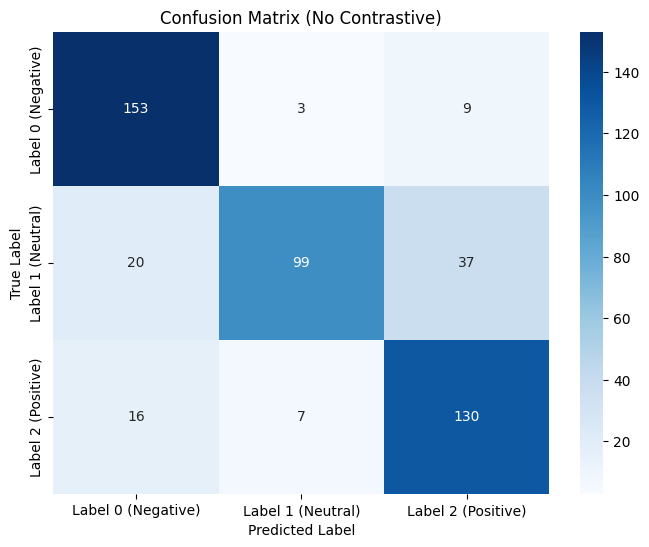

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_test_preds = []
all_test_labels = []
test_loss_total = 0.0
test_steps = 0

with torch.no_grad():
    z_dict_test = model(test_data.x_dict, test_data.edge_index_dict)
    edge_idx_test = test_data['drug', 'interacts', 'food'].pos_edge_label_index
    test_labels = test_data['drug', 'interacts', 'food'].pos_edge_label

    if edge_idx_test.numel() > 0:
        test_logits = model.decode(z_dict_test, edge_idx_test)
        test_loss = ce_loss(test_logits, test_labels)
        test_loss_total += test_loss.item()
        test_steps += 1

        preds = test_logits.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(test_labels.cpu().numpy())
    else:
        print("\nWarning: No positive test edges found for final testing.")

avg_test_loss = test_loss_total / test_steps if test_steps > 0 else 0.0
overall_test_acc = accuracy_score(all_test_labels, all_test_preds) if all_test_labels else 0.0

print(f"\n[NO Contrastive] Final Test Loss (Avg): {avg_test_loss:.4f} | Final Test Accuracy: {overall_test_acc:.4f}")


if all_test_labels:
    print("\n" + "="*30)
    print(" Test Set Evaluation Results ")
    print("="*30)
    target_names = ['Label 0 (Negative)', 'Label 1 (Neutral)', 'Label 2 (Positive)']
    present_labels = sorted(np.unique(all_test_labels + all_test_preds))
    report_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

    print("Classification Report:")
    try:
        report = classification_report(all_test_labels, all_test_preds,
                                       labels=present_labels,
                                       target_names=report_target_names,
                                       digits=4,
                                       zero_division=0)
        print(report)
    except ValueError as e:
         print(f"Could not generate classification report: {e}")
         print("Check if labels/predictions contain unexpected values.")
         print("True labels present:", np.unique(all_test_labels))
         print("Predicted labels present:", np.unique(all_test_preds))

    print("\nConfusion Matrix:")
    try:
        cm = confusion_matrix(all_test_labels, all_test_preds, labels=present_labels)
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=report_target_names,
                    yticklabels=report_target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (No Contrastive)')
        plt.show()
    except Exception as e:
        print(f"Could not generate or plot confusion matrix: {e}")

else:
    print("\nNo test predictions were made (e.g., empty test set or no positive links). Cannot evaluate metrics.")


In [ ]:
print("\nSample Predictions:")
num_samples = 10

if edge_idx_test.numel() > 0 and all_test_labels:
    if len(all_test_preds) == edge_idx_test.size(1):
        num_available = len(all_test_preds)
        indices_to_sample = min(num_samples, num_available)
        if indices_to_sample > 0:
             sample_indices = np.random.choice(num_available, indices_to_sample, replace=False)
             sample_edge_idx = edge_idx_test[:, sample_indices]
             sample_preds = torch.tensor(np.array(all_test_preds)[sample_indices], device=device)
             sample_true = torch.tensor(np.array(all_test_labels)[sample_indices], device=device)
        else:
             sample_preds = torch.tensor([])
    else:
         print("Warning: Mismatch in collected predictions length or no predictions. Generating fresh sample predictions.")
         num_available = edge_idx_test.size(1)
         indices_to_sample = min(num_samples, num_available)
         if indices_to_sample > 0:
            sample_indices_perm = torch.randperm(num_available)[:indices_to_sample]
            sample_edge_idx = edge_idx_test[:, sample_indices_perm]
            with torch.no_grad():
                 sample_logits = model.decode(z_dict_test, sample_edge_idx)
            sample_preds = sample_logits.argmax(dim=1)
            sample_true = test_labels[sample_indices_perm]
         else:
             sample_preds = torch.tensor([]) # Handle case of zero samples

    if len(sample_preds) > 0:
        inv_drug_le = {v: k for k, v in enumerate(drug_le.classes_)}
        inv_food_le = {v: k for k, v in enumerate(food_le.classes_)}

        for i in range(len(sample_preds)):
            drug_id = sample_edge_idx[0, i].item()
            food_id = sample_edge_idx[1, i].item()
            drug_name = drug_le.inverse_transform([drug_id])[0]
            food_name = food_le.inverse_transform([food_id])[0]
            pred_label = sample_preds[i].item()
            true_label = sample_true[i].item()
            print(f"{i+1}: Drug: {drug_name:<25} | Food: {food_name:<25} | Predicted: {pred_label} | Actual: {true_label}")
    else:
        print("Could not generate samples (not enough data or issue during sampling).")
else:
     print("No samples to show (test set has no positive edges or no labels were collected).")


Sample Predictions:
1: Drug: Statin                    | Food: thiamine                  | Predicted: 2 | Actual: 2
2: Drug: ACE inhibitor             | Food: butein                    | Predicted: 2 | Actual: 2
3: Drug: Acetaminophen             | Food: saturated fatty acids     | Predicted: 1 | Actual: 2
4: Drug: Statin                    | Food: benzophenone              | Predicted: 1 | Actual: 1
5: Drug: GLP-1                     | Food: cytosine                  | Predicted: 0 | Actual: 0
6: Drug: Thyroxine                 | Food: brazil nut                | Predicted: 0 | Actual: 1
7: Drug: Acetaminophen             | Food: cinnamaldehyde            | Predicted: 2 | Actual: 1
8: Drug: Statin                    | Food: arsenic                   | Predicted: 0 | Actual: 0
9: Drug: ACE inhibitor             | Food: vitis                     | Predicted: 2 | Actual: 2
10: Drug: GLP-1                     | Food: erythritol                | Predicted: 1 | Actual: 2


Using 'pos_edge_label' for stratification.
Attempting stratified sampling for target 150 edges...
  Label 0: Available=1256, Target=50, Sampled=50
  Label 1: Available=1272, Target=50, Sampled=50
  Label 2: Available=1267, Target=50, Sampled=50
Total edges selected for visualization: 150


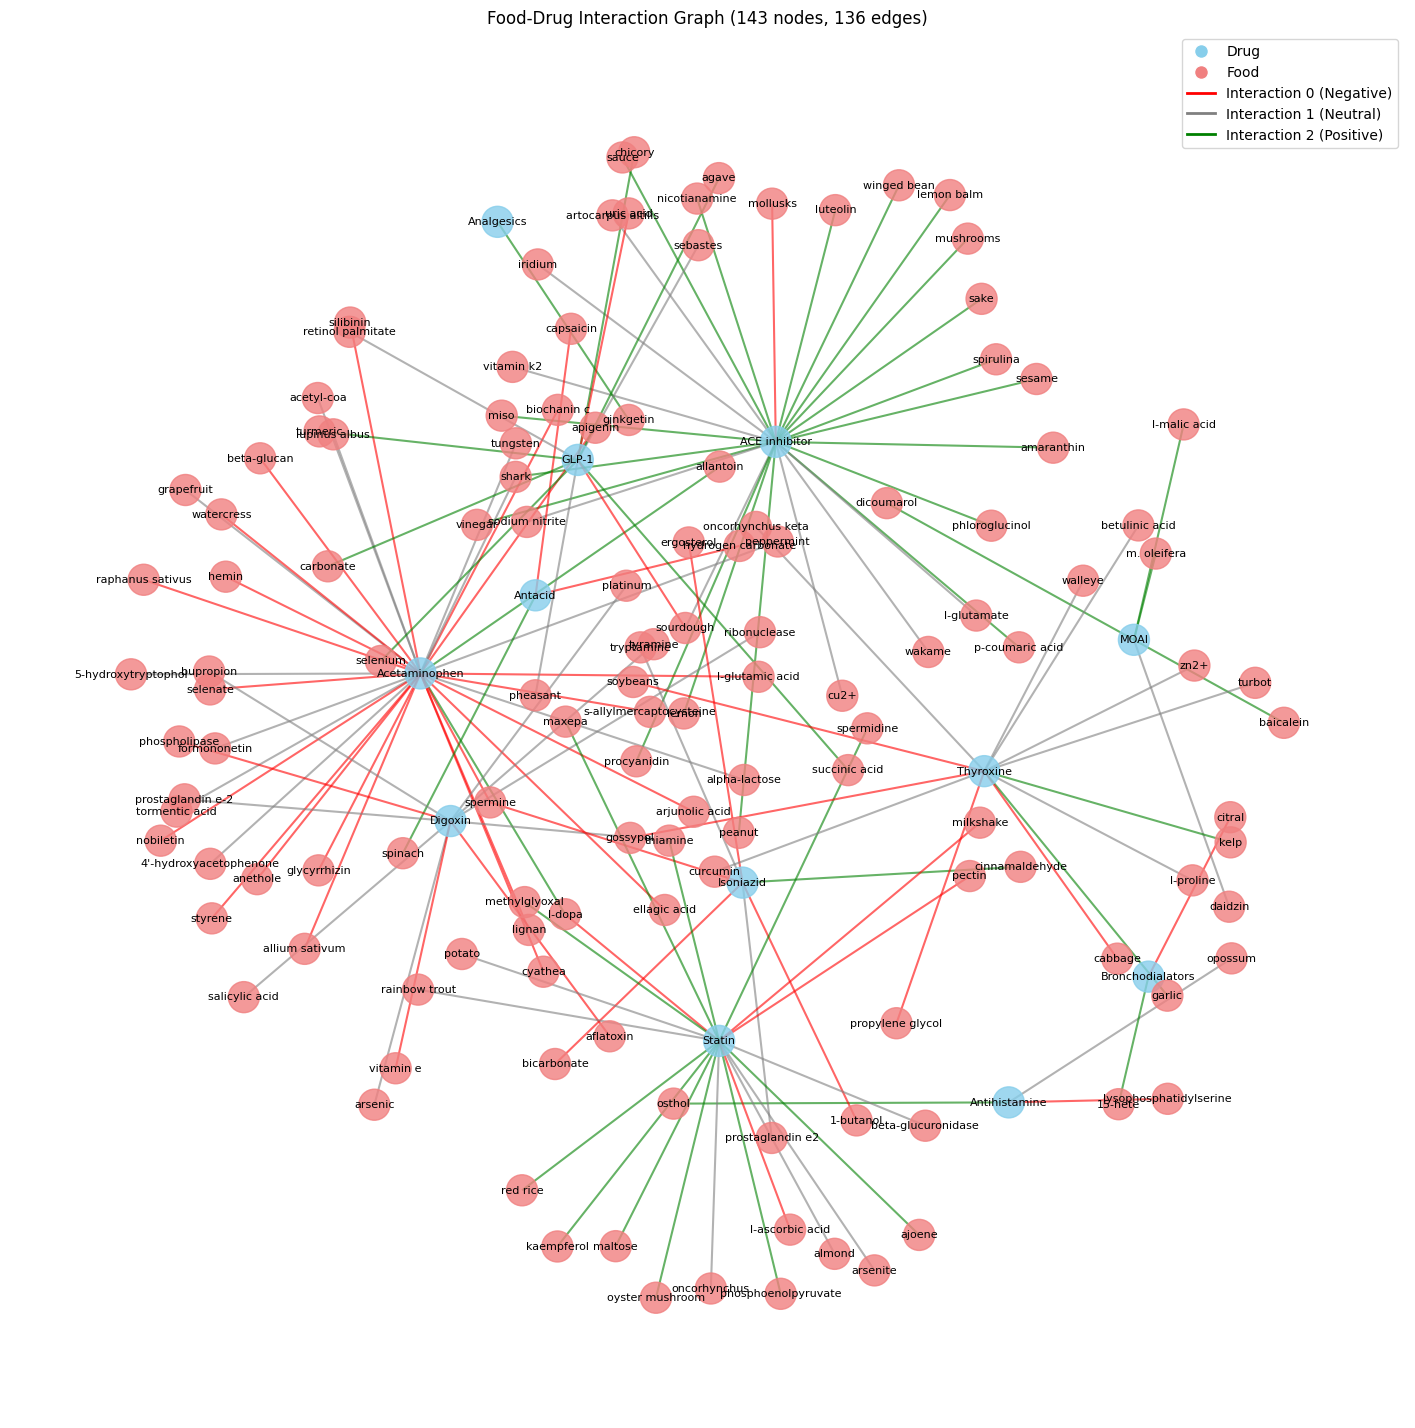

In [ ]:
#Visualization

import networkx as nx
import matplotlib.pyplot as plt
import random
import torch
from collections import defaultdict

vis_data = train_data

num_edges_to_vis = 150
try:
    full_edge_index = vis_data['drug', 'interacts', 'food'].edge_index
    if hasattr(vis_data['drug', 'interacts', 'food'], 'pos_edge_label'):
        full_edge_label = vis_data['drug', 'interacts', 'food'].pos_edge_label
        print("Using 'pos_edge_label' for stratification.")
    elif hasattr(vis_data['drug', 'interacts', 'food'], 'edge_label'):
         full_edge_label = vis_data['drug', 'interacts', 'food'].edge_label
         print("Using 'edge_label' for stratification.")
    else:
        full_edge_label = None
        print("Warning: Could not find edge labels ('pos_edge_label' or 'edge_label'). Cannot perform stratified sampling.")

    if full_edge_label is not None and full_edge_index.size(1) != full_edge_label.size(0):
        print(f"Warning: Edge index size ({full_edge_index.size(1)}) != Edge label size ({full_edge_label.size(0)}). Cannot perform stratified sampling.")
        full_edge_label = None

except KeyError:
    print("Error: Could not access edge data ['drug', 'interacts', 'food'] in vis_data.")
    raise SystemExit("Cannot proceed with visualization due to missing edge data.")


vis_edge_index = None
vis_edge_label = None

if full_edge_label is None:
    print("Falling back to simple random sampling (no stratification).")
    num_available = full_edge_index.size(1)
    num_to_sample = min(num_edges_to_vis, num_available)
    if num_to_sample > 0:
        sample_indices = random.sample(range(num_available), num_to_sample)
        vis_edge_index = full_edge_index[:, sample_indices]
        print(f"Visualizing a simple random sample of {num_to_sample} edges.")
    else:
        print("No edges available to visualize.")
        plt.figure(figsize=(5, 2))
        plt.text(0.5, 0.5, 'No edges to visualize in this data split.', ha='center', va='center')
        plt.axis('off')
        plt.show()

else:
    print(f"Attempting stratified sampling for target {num_edges_to_vis} edges...")
    target_per_class = num_edges_to_vis
    indices_by_label = defaultdict(list)

    for i in range(full_edge_label.size(0)):
        label = full_edge_label[i].item()
        indices_by_label[label].append(i)

    final_sampled_indices = []
    total_sampled = 0

    for label_val in range(3):
        available_indices = indices_by_label[label_val]
        num_available = len(available_indices)
        num_to_sample = min(target_per_class, num_available)

        if num_to_sample > 0:
            sampled = random.sample(available_indices, num_to_sample)
            final_sampled_indices.extend(sampled)
            total_sampled += num_to_sample
        print(f"  Label {label_val}: Available={num_available}, Target={target_per_class}, Sampled={num_to_sample}")

    remaining_needed = num_edges_to_vis - total_sampled
    if remaining_needed > 0:
        print(f"  Topping up {remaining_needed} edges...")
        all_indices = set(range(full_edge_label.size(0)))
        used_indices = set(final_sampled_indices)
        unused_indices = list(all_indices - used_indices)
        num_to_sample_extra = min(remaining_needed, len(unused_indices))
        if num_to_sample_extra > 0:
            extra_sampled = random.sample(unused_indices, num_to_sample_extra)
            final_sampled_indices.extend(extra_sampled)
            print(f"  Added {num_to_sample_extra} extra edges randomly.")

    random.shuffle(final_sampled_indices)
    print(f"Total edges selected for visualization: {len(final_sampled_indices)}")

    if final_sampled_indices:
      vis_edge_index = full_edge_index[:, final_sampled_indices]
      vis_edge_label = full_edge_label[final_sampled_indices]
    else:
        print("No edges were sampled after stratification (perhaps empty split?).")

if vis_edge_index is not None:

    G = nx.Graph()

    involved_drug_nodes = torch.unique(vis_edge_index[0]).cpu().tolist()
    involved_food_nodes = torch.unique(vis_edge_index[1]).cpu().tolist()

    node_labels = {}
    node_colors = []
    node_list = []
    for drug_id in involved_drug_nodes:
        node_id = ('drug', drug_id)
        G.add_node(node_id, type='drug')
        try:
            node_labels[node_id] = drug_le.inverse_transform([drug_id])[0]
        except ValueError:
            node_labels[node_id] = f"Drug_{drug_id}"
        node_colors.append('skyblue')
        node_list.append(node_id)

    for food_id in involved_food_nodes:
        node_id = ('food', food_id)
        G.add_node(node_id, type='food')
        try:
            node_labels[node_id] = food_le.inverse_transform([food_id])[0]
        except ValueError:
             node_labels[node_id] = f"Food_{food_id}"
        node_colors.append('lightcoral')
        node_list.append(node_id)

    edge_color_map = {0: 'red', 1: 'gray', 2: 'green'}

    for i in range(vis_edge_index.size(1)):
        drug_id = vis_edge_index[0, i].item()
        food_id = vis_edge_index[1, i].item()
        source_node = ('drug', drug_id)
        target_node = ('food', food_id)

        label = vis_edge_label[i].item() if vis_edge_label is not None else 1
        edge_color = edge_color_map.get(label, 'black')
        if G.has_node(source_node) and G.has_node(target_node):
            G.add_edge(source_node, target_node, label=label)

    if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
        plt.figure(figsize=(18, 18))
        pos = nx.spring_layout(G, k=0.4, iterations=50)
        nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=node_colors, node_size=500, alpha=0.8)
        drawn_edges = G.edges(data=True)
        edge_color_list = [edge_color_map.get(data.get('label', 1), 'black') for u, v, data in drawn_edges]
        nx.draw_networkx_edges(G, pos, edgelist=drawn_edges, edge_color=edge_color_list, alpha=0.6, width=1.5)

        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

        plt.title(f"Food-Drug Interaction Graph ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
        plt.axis('off')

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', label='Drug', markerfacecolor='skyblue', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Food', markerfacecolor='lightcoral', markersize=10),
            plt.Line2D([0], [0], color='red', lw=2, label='Interaction 0 (Negative)'),
            plt.Line2D([0], [0], color='gray', lw=2, label='Interaction 1 (Neutral)'),
            plt.Line2D([0], [0], color='green', lw=2, label='Interaction 2 (Positive)')
        ]
        plt.legend(handles=legend_elements, loc='best')

        plt.show()
    elif G.number_of_nodes() == 0:
        print("Final graph has no nodes to draw.")
    else:
        print("Final graph has no edges to draw.")
